In [35]:
## Data loading, processing and for more
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# set seaborn style because it prettier
sns.set()

## Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

## Models
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [36]:

# read the data and show first 5 rows
data = pd.read_csv("bs140513_032310.csv")
data.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


# Explaratory Data Analysis

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


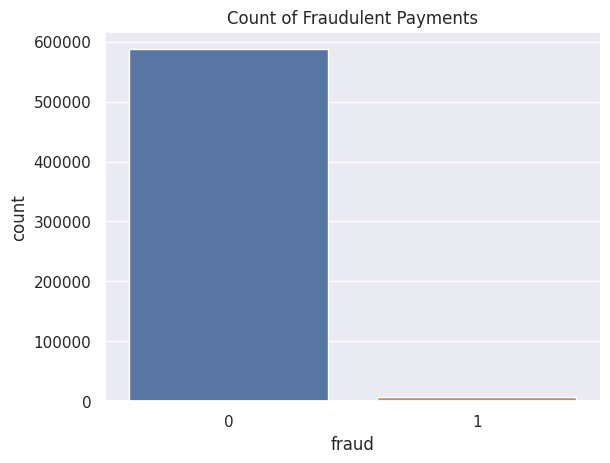

Number of normal examples:  587443
Number of fradulent examples:  7200


In [38]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = data.loc[data.fraud == 1] 
df_non_fraud = data.loc[data.fraud == 0]

sns.countplot(x="fraud",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",df_non_fraud.fraud.count())
print("Number of fradulent examples: ",df_fraud.fraud.count())
#print(data.fraud.value_counts()) # does the same thing above

In [39]:
print("Mean feature values per category",data.groupby('category')['amount','fraud'].mean())

Mean feature values per category                               amount     fraud
category                                      
'es_barsandrestaurants'    43.461014  0.018829
'es_contents'              44.547571  0.000000
'es_fashion'               65.666642  0.017973
'es_food'                  37.070405  0.000000
'es_health'               135.621367  0.105126
'es_home'                 165.670846  0.152064
'es_hotelservices'        205.614249  0.314220
'es_hyper'                 45.970421  0.045917
'es_leisure'              288.911303  0.949900
'es_otherservices'        135.881524  0.250000
'es_sportsandtoys'        215.715280  0.495252
'es_tech'                 120.947937  0.066667
'es_transportation'        26.958187  0.000000
'es_travel'              2250.409190  0.793956
'es_wellnessandbeauty'     65.511221  0.047594


<ipython-input-39-cc3083ece405>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print("Mean feature values per category",data.groupby('category')['amount','fraud'].mean())


In [40]:
# Create two dataframes with fraud and non-fraud data 
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           data.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
category,,,
'es_transportation',NaN,26.958187,0.000000
'es_food',NaN,37.070405,0.000000
'es_hyper',169.255429,40.037145,4.591669
'es_barsandrestaurants',164.092667,41.145997,1.882944
'es_contents',NaN,44.547571,0.000000
'es_wellnessandbeauty',229.422535,57.320219,4.759380
'es_fashion',247.008190,62.347674,1.797335
'es_leisure',300.286878,73.230400,94.989980
'es_otherservices',316.469605,75.685497,25.000000


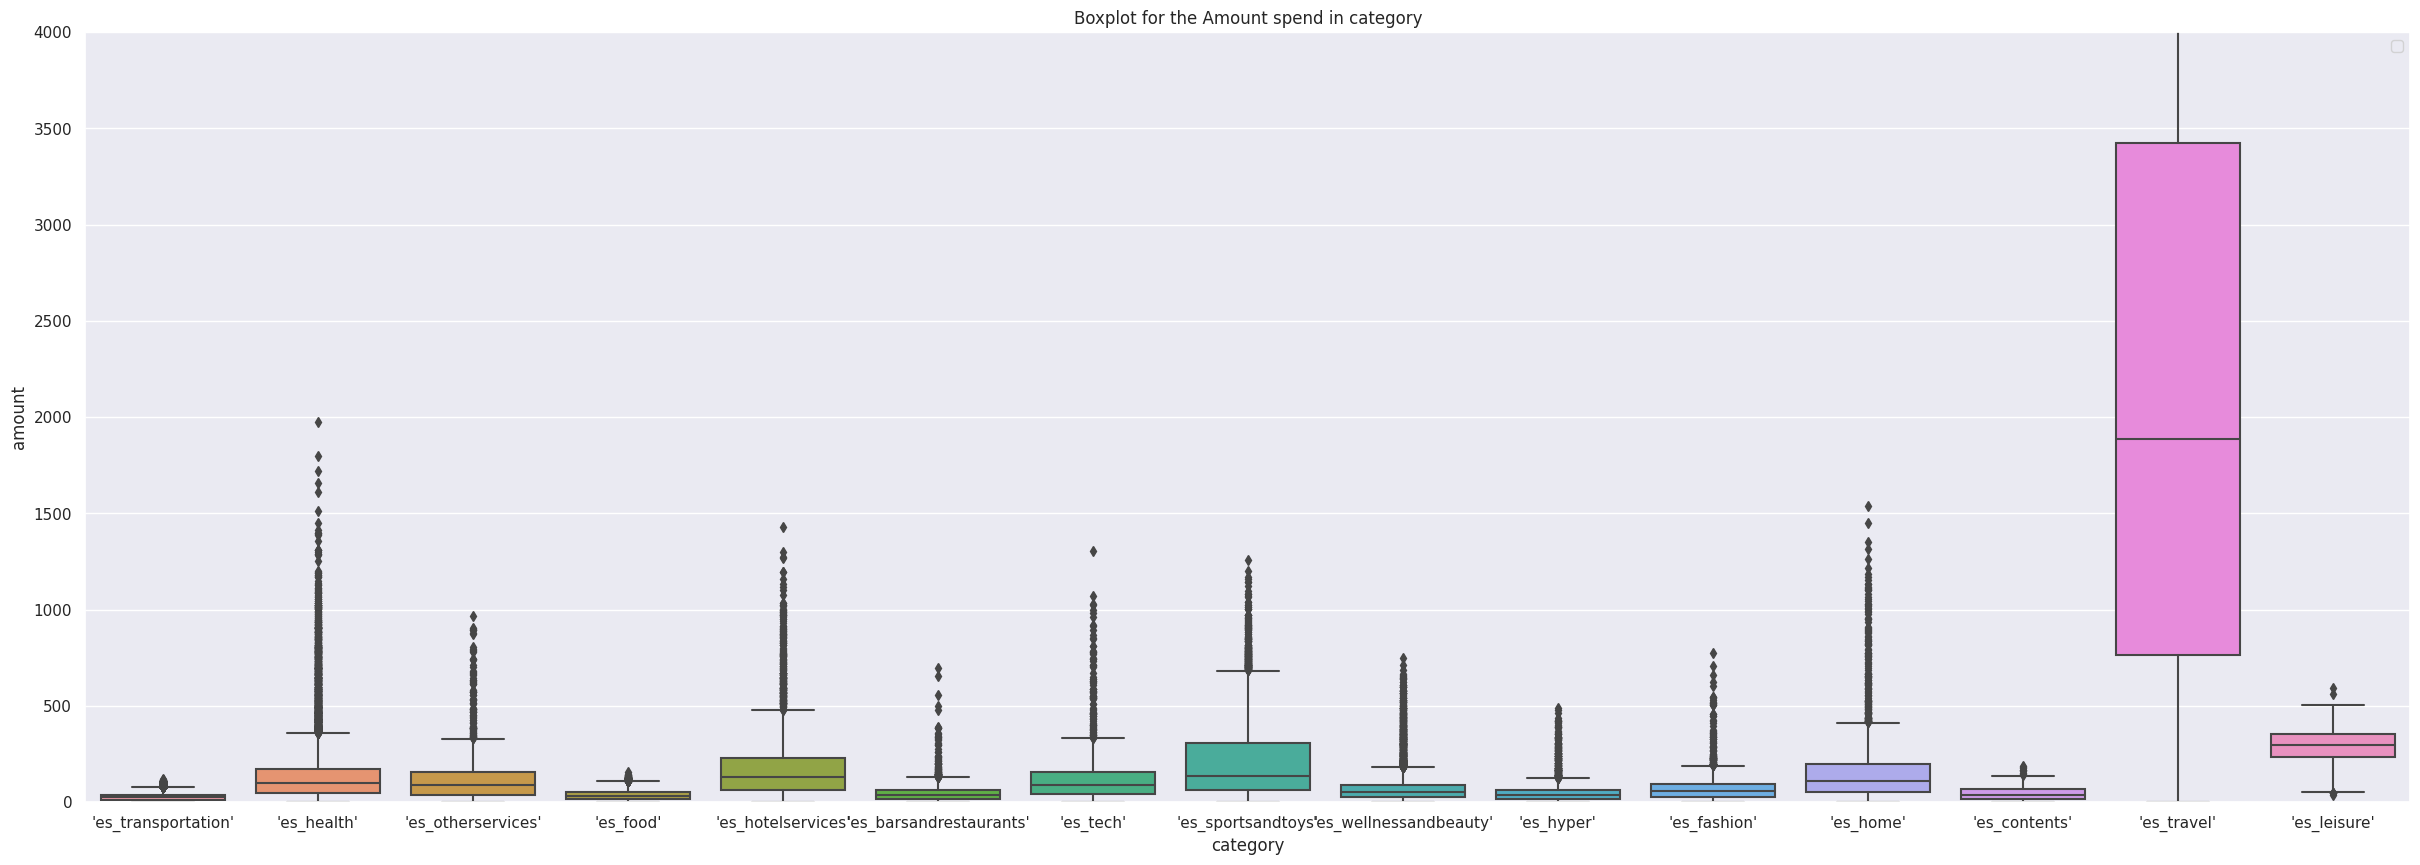

In [41]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.figure(figsize=(30,10))
sns.boxplot(x=data.category,y=data.amount)
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0,4000)
plt.legend()
plt.show()

In [42]:
print((data.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7  'U'       0.594228
6  '6'       0.974826
5  '5'       1.095112
1  '1'       1.185254
3  '3'       1.192815
2  '2'       1.251401
4  '4'       1.293281
0  '0'       1.957586


# Data Preprocessing

In [43]:
print("Unique zipCodeOri values: ",data.zipcodeOri.nunique())
print("Unique zipMerchant values: ",data.zipMerchant.nunique())
# dropping zipcodeori and zipMerchant since they have only one unique value
data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


In [44]:
data_reduced.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

In [45]:
# turning object columns type to categorical for easing the transformation process
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


In [46]:
X = data_reduced.drop(['fraud'],axis=1)
y = data['fraud']
print(X.head(),"\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0       210    4       2        30        12    4.55
1     0      2753    2       2        30        12   39.68
2     0      2285    4       1        18        12   26.89
3     0      1650    3       2        30        12   17.25
4     0      3585    5       2        30        12   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


In [47]:
X1 = data_reduced[data_reduced['fraud']==1]
X1 = X1.drop(['fraud'], axis=1)
y1 = data['fraud'][data['fraud']==1]
print(X1.head(),"\n")
print(y1.head())

     step  customer  age  gender  merchant  category  amount
88      0      3219    3       2        34         4   44.26
89      0       723    3       2        34         4  324.50
434     0       362    3       2        44         6  176.32
435     0      4040    3       2        44         6  337.41
553     0       969    4       1         2        14  220.11 

88     1
89     1
434    1
435    1
553    1
Name: fraud, dtype: int64


In [48]:
y[y==1].count()

7200

In [49]:
sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

In [51]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1,test_size=0.2,random_state=42,shuffle=True)

In [52]:
def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [53]:
# The base score should be better than predicting always non-fraduelent
print("Base accuracy score we must beat is: ", 
      df_non_fraud.fraud.count()/ np.add(df_non_fraud.fraud.count(),df_fraud.fraud.count()) * 100)

Base accuracy score we must beat is:  98.7891894800746


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for SVM Regression: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.48      0.65      1440

    accuracy                           0.48      1440
   macro avg       0.50      0.24      0.32      1440
weighted avg       1.00      0.48      0.65      1440

Confusion Matrix of SVM Regression: 
 [[  0   0]
 [751 689]]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


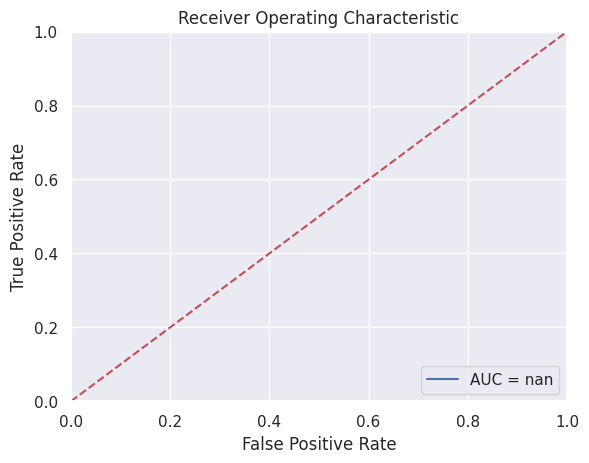

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
# from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test1)
print("Classification Report for SVM Regression: \n", classification_report(y_test1, y_pred))
print("Confusion Matrix of SVM Regression: \n", confusion_matrix(y_test1,y_pred))
plot_roc_auc(y_test1, svm.predict_proba(X_test1)[:,1])

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWar

Classification Report for XGB Classifier: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.84      0.91      1440

    accuracy                           0.84      1440
   macro avg       0.50      0.42      0.46      1440
weighted avg       1.00      0.84      0.91      1440



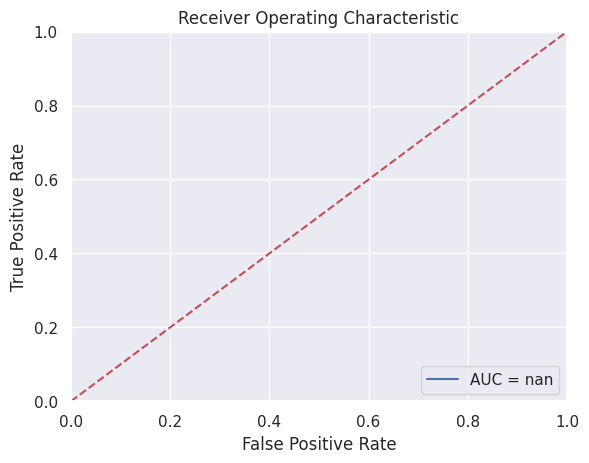

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


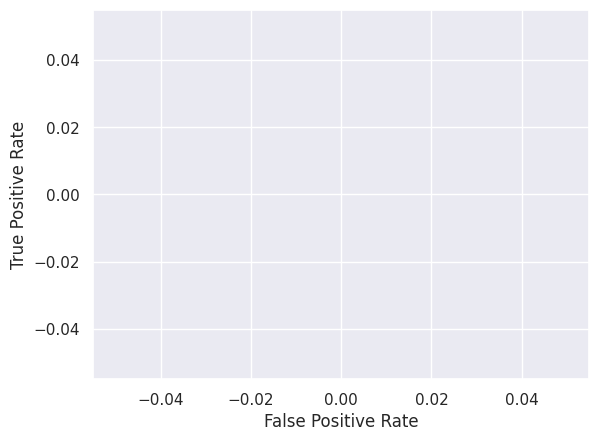

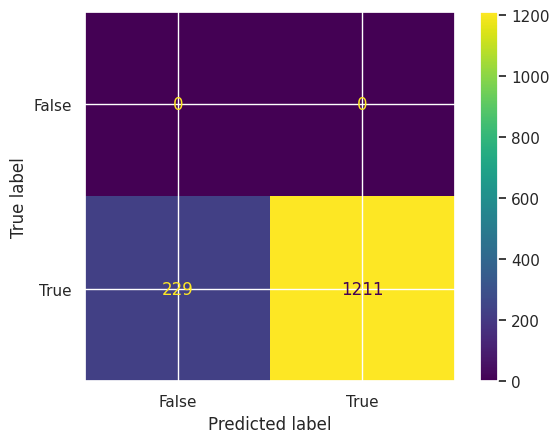

In [58]:
from xgboost import XGBClassifier
from sklearn import metrics
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred =  xgb.predict(X_test1)
print("Classification Report for XGB Classifier: \n", classification_report(y_test1, y_pred))
# print("Confusion Matrix of XGB Classifier: \n", confusion_matrix(y_test1,y_pred))
plot_roc_auc(y_test1, xgb.predict_proba(X_test1)[:,1])
fpr, tpr, _ = metrics.roc_curve(y_test1,  xgb.predict_proba(X_test1)[:,1])

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

confusion_matrix = metrics.confusion_matrix(y_test1, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samp

Classification Report for Logistic Regression: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.53      0.70      1440

    accuracy                           0.53      1440
   macro avg       0.50      0.27      0.35      1440
weighted avg       1.00      0.53      0.70      1440

Confusion Matrix of Logistic Regression: 
 [[  0   0]
 [671 769]]


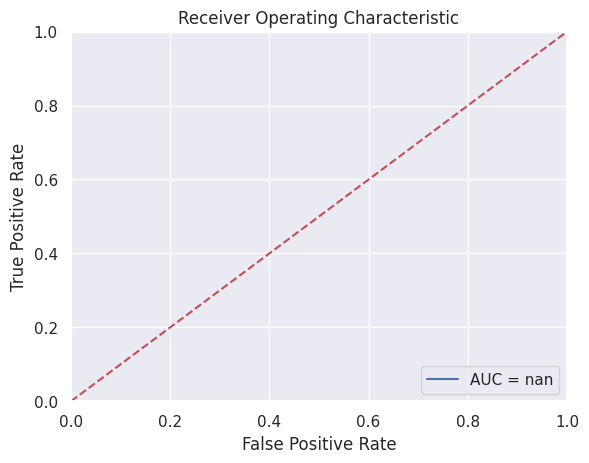

In [34]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test1)
print("Classification Report for Logistic Regression: \n", classification_report(y_test1, y_pred))
print("Confusion Matrix of Logistic Regression: \n", confusion_matrix(y_test1,y_pred))
plot_roc_auc(y_test1, logreg.predict_proba(X_test1)[:,1])

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWar

Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.53      0.70      1440

    accuracy                           0.53      1440
   macro avg       0.50      0.27      0.35      1440
weighted avg       1.00      0.53      0.70      1440

Confusion Matrix of K-Nearest Neigbours: 
 [[  0   0]
 [670 770]]


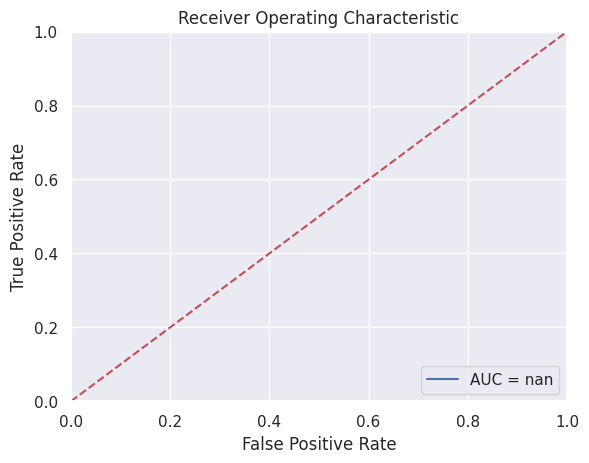

In [29]:
# %% K-ello Neigbors

knn = KNeighborsClassifier(n_neighbors=100,p=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test1)


print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test1, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test1,y_pred))
plot_roc_auc(y_test1, knn.predict_proba(X_test1)[:,1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   57.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMet

Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.94      0.97      1440

    accuracy                           0.94      1440
   macro avg       0.50      0.47      0.48      1440
weighted avg       1.00      0.94      0.97      1440

Confusion Matrix of Random Forest Classifier: 
 [[   0    0]
 [  84 1356]]


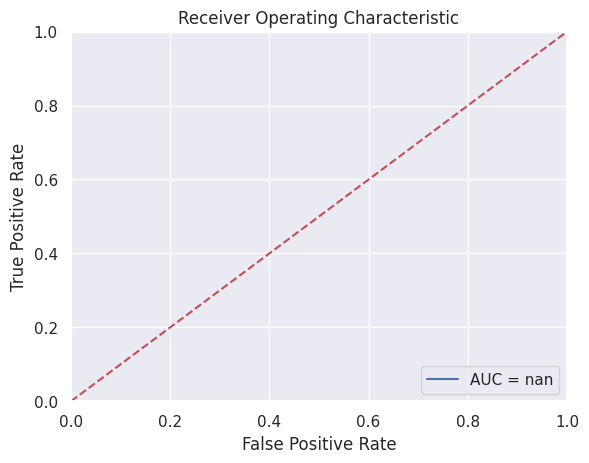

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


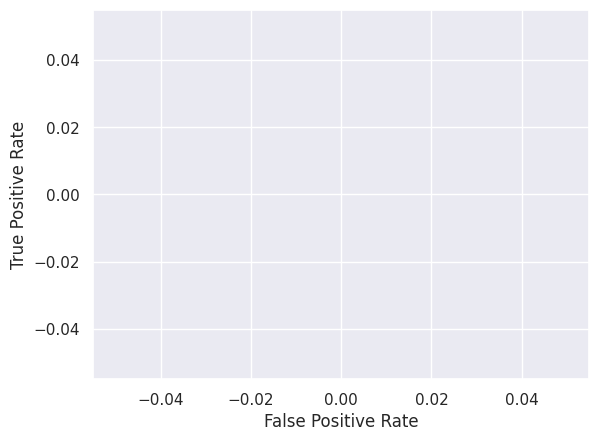

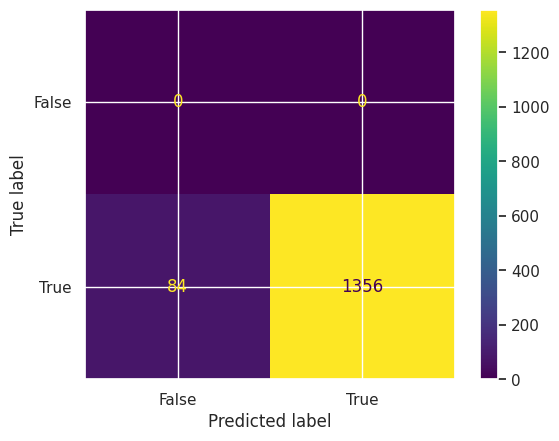

In [56]:
# %% Random Forest Classifier
from sklearn import metrics

rf_clf = RandomForestClassifier(n_estimators=500,max_depth=1,random_state=42,
                                verbose=1,class_weight="balanced")

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test1)

print("Classification Report for Random Forest Classifier: \n", classification_report(y_test1, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test1,y_pred))
plot_roc_auc(y_test1, rf_clf.predict_proba(X_test1)[:,1])
fpr, tpr, _ = metrics.roc_curve(y_test1,  rf_clf.predict_proba(X_test1)[:,1])

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

confusion_matrix = metrics.confusion_matrix(y_test1, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()